# Paytm

In [53]:
# Load necessary libraries
import sys
import warnings
warnings.filterwarnings('ignore')
import datetime
import gensim
import pandas as pd
import tqdm.notebook as tqdm
from tqdm.auto import tqdm
tqdm.pandas()

sys.path.append('/Users/pushkar/Documents/projects/fin_comp/comp/docs')

import utils.helper
from utils.helper import Processor
import importlib
importlib.reload(utils.helper)

import plotly.io as pio
svg_renderer = pio.renderers["svg"]
svg_renderer.width = 900
svg_renderer.height = 500
pio.renderers.default = "svg"
import plotly.express as px

In [2]:
# Load data
df = pd.read_csv('./../../data/fintech/paytm/paytm.csv', engine='python')

In [30]:
# Company username
company_username = 'Paytmcare'

In [4]:
# Correct the format of variables
df['inReplyToTweetId'] = df['inReplyToTweetId'].apply(lambda x: '%.0f' % x).values.tolist()
df['conversation_id'] = df['conversation_id'].astype(str)

In [5]:
df = df[~df['date'].str.contains("http", na=False)]

In [6]:
# Declare the query words
query_words = ['dm', 'customer experience', 'inconvenience', 'concern team', 'resolve', 
                'solve', 'no noc', 'await response', 'unpleasant experience']

In [7]:
# Declare the processor object
processor = Processor('./../../data/config.json')

In [8]:
# Check whether an observation is query for the company or not
df['is_query'] = 0

for word in tqdm(query_words):
    df['is_query'] = df['is_query'] + df['tweet'].apply(processor.word_distribution, find=word).astype(int)

  0%|          | 0/9 [00:00<?, ?it/s]

In [31]:
# Select observations of queries
qdf = df[(df['is_query']>0) & (df['username'] == company_username)]

In [33]:
qdf.shape

(3459, 28)

In [34]:
# Get all the conversation ids
conversation_ids = qdf['conversation_id'].unique()
print(f"Total number of unique conversations: {len(conversation_ids)}")

Total number of unique conversations: 3358


In [35]:
df['date'] = pd.to_datetime(df['date'])

## Response time

Response time is the time the company takes to respond to the first query.

In [36]:
result = pd.DataFrame()
result['conversation_id'] = conversation_ids
result['response_time'] = 0

In [38]:
for index, conversation_id in tqdm(enumerate(conversation_ids)):
    tmp = df[df['conversation_id'] == conversation_id]
    tmp.sort_values('date', ascending=True, inplace=True)
    comp_tmp = tmp[tmp['username'] == company_username]
    response_time = (comp_tmp.iloc[0]['date'] - tmp.iloc[0]['date']) / datetime.timedelta(hours=1)
    result.at[index, 'response_time'] = response_time

0it [00:00, ?it/s]

In [39]:
result

,conversation_id,response_time
0,1344016717694042114,1.860833
1,1344186330482262016,0.860000
2,1343909218022117378,0.000000
3,1343164305173147648,0.015556
4,1341356011563565059,4.873333
...,...,...
3353,1080341597475106816,0.000000
3354,1080108275478204421,0.000000
3355,1080103861594013696,0.000000
3356,1080034600405983233,0.000000


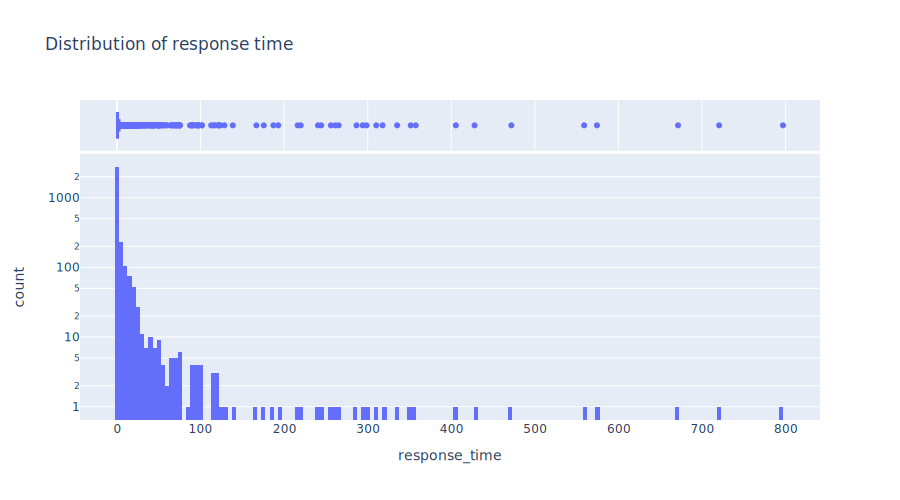

In [40]:
fig = px.histogram(result[result['response_time']<1000], x='response_time', log_y=True, marginal='box', title='Distribution of response time')
fig.show()

## Resolution time

Assuming that if the last query in the conversation is from the company then the issue is resolved.  
Resolution time is the time difference between the last date of last tweet in the conversation and the date of first query.

In [41]:
result['resolution_time'] = 0

In [43]:
for index, conversation_id in tqdm(enumerate(conversation_ids)):
    tmp = df[df['conversation_id'] == conversation_id]
    tmp.sort_values('date', ascending=True, inplace=True)
    comp_tmp = tmp[tmp['username'] == company_username]
    if tmp.iloc[-1]['username'] == company_username:
        resolution_time = (tmp.iloc[-1]['date'] - tmp.iloc[0]['date']) / datetime.timedelta(hours=1)
        result.at[index, 'resolution_time'] = resolution_time

0it [00:00, ?it/s]

In [44]:
print(f"Number of queries resolved: {len(result['resolution_time'].to_numpy().nonzero()[0])}")
print(f"Number of queries unresolved: {result.shape[0] - len(result['resolution_time'].to_numpy().nonzero()[0])}")

Number of queries resolved: 1897
Number of queries unresolved: 1461


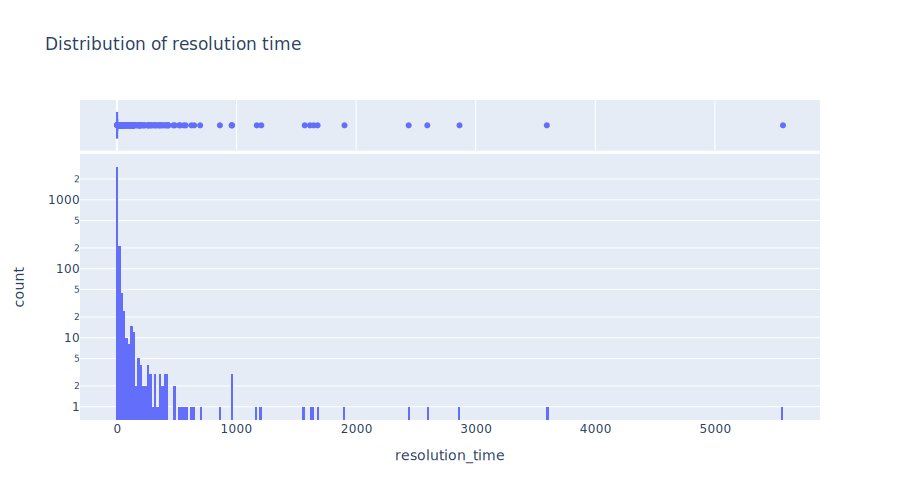

In [45]:
fig = px.histogram(result, x='resolution_time', log_y=True, marginal='box', title='Distribution of resolution time')
fig.show()

In [46]:
result.describe()

,response_time,resolution_time
count,3358.000000,3358.000000
mean,8.922587,18.402760
std,83.857372,164.904065
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.236806,0.148333
75%,1.241319,1.362917
max,3356.318056,5569.472222


## Query Tweets Topics

In [47]:
queries = df[df['conversation_id'].isin(conversation_ids)]
queries.sort_values('date', ascending=True, inplace=True)
queries = queries[queries['inReplyToTweetId'] == 'nan']
queries.shape

(2286, 28)

In [55]:
processor = Processor('./../../data/config.json')
queries = processor.preprocess_individual(queries)
id2word = gensim.corpora.Dictionary(queries['bigram'].values.tolist())
corpus = [id2word.doc2bow(text) for text in queries['bigram'].values.tolist()]


In [56]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=4,
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True,
                                        alpha='symmetric',
                                        eta=0.3)
coherence_model = gensim.models.CoherenceModel(model=lda_model, 
                                                    texts=queries['bigram'].values.tolist(), 
                                                    dictionary=id2word, 
                                                    coherence='u_mass')
coherence_model_score = coherence_model.get_coherence()
print('Coherence Score: ', coherence_model_score)
import pyLDAvis.gensim_models

import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

Coherence Score:  -5.18592817717386


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.135909 -0.012835       1        1  37.817658
3     -0.049905 -0.097213       2        1  21.979946
0     -0.025169  0.100595       3        1  21.831034
1     -0.060835  0.009454       4        1  18.371362, topic_info=               Term        Freq       Total Category  logprob  loglift
268        postpaid  438.000000  438.000000  Default  30.0000  30.0000
4               kyc  128.000000  128.000000  Default  29.0000  29.0000
48            order   67.000000   67.000000  Default  28.0000  28.0000
129   dm_registered   79.000000   79.000000  Default  27.0000  27.0000
1822     order_help   76.000000   76.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
215            need   13.204980   60.453288   Topic4  -5.8167   0.1731
216            time   14.739514  105.421727   Topic4  -5.7067  -0.2731
289           offer   12.662379   77.572585   Topic4  -5.8586  -0.1182
183           issue   12.837839   87.597754   Topic4  -5.8449  -0.2260
307             pay   13.164885  113.640618   Topic4  -5.8197  -0.4611

[315 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
569       1  0.530316      able
569       2  0.125601      able
569       3  0.055823      able
569       4  0.307025      able
137       1  0.760145  able_use
...     ...       ...       ...
810       2  0.012886   working
810       3  0.090199   working
810       4  0.244825   working
1895      1  0.904933      zero
61        2  0.951542    zomato

[533 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2])

In [57]:
queries_topic_sents_keywords = processor.dominant_topics(ldamodel=lda_model, 
                                                         corpus=corpus, 
                                                         texts=queries['bigram'].values.tolist(),
                                                         tweets=queries['tweet'].values.tolist())
queries_topic_sents_keywords['Topic_Keywords'].unique()

array(['postpaid, account, kyc, wallet, payment, money, mobile_number, recharge, option, app',
       'app, help, payment, thanks, number, account, days, need, query, refund',
       'order, wallet, membership, app, money, payment, offer, offers, cashback, got',
       'gold, month, app, cashback, number, money, account, received, postpaid, paid'],
      dtype=object)

In [58]:
select = queries_topic_sents_keywords['Topic_Keywords'].unique()[1]
queries_topic_sents_keywords[queries_topic_sents_keywords['Topic_Keywords'] == select]['Text'].values

array(['@HAMPIREDDY97 \n  \n   Hi! Please  share  your Paytm  registered mobile number and  Email Id  to assist you better Via  DM.Thanks!\n   https://t.co/5m1Urzybmc',
       '@mdminhaz484 Hi, If you wish to close your Paytm wallet account, please share your registered mobile number with us over DM. Our team will reach out to you.   https://t.co/5m1Urzybmc',
       "@Paytmcare Paytm your service is really pathetic on 1 Jan 2018 my 3000rs automatically transferred from wallet to my paytm bank when I ask to Cc he said sir we can't help you is this your security and u also chargers me 120rs which I didn't initiate 😡😡😡😡😡",
       '@Paytm  I am trying to reset my password by calling the customer care number with my registered number, but the auto response say "It seems you have not entered the key" no matter how many times I press it',
       '@Paytm amount deducted have been not yet resolved on 28.12.18 ,no response till now.',
       '@mdriyaz13007230 Hi, we are keen to help you. Please 

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



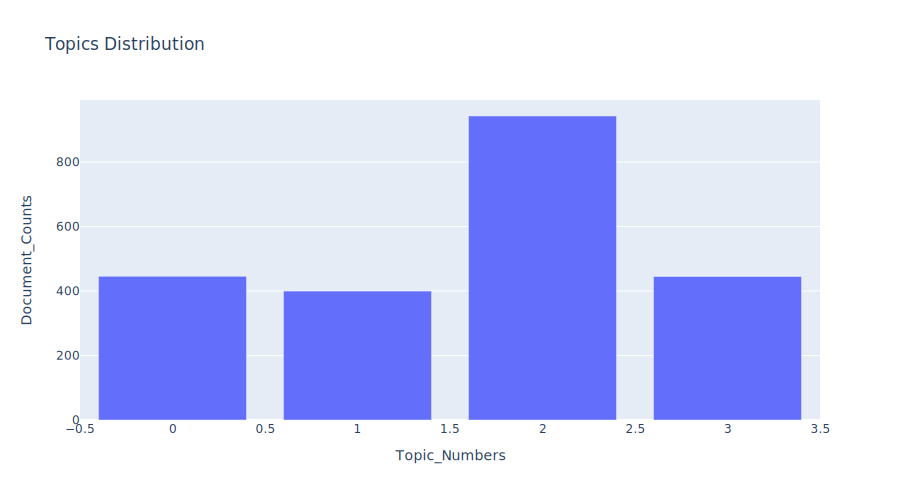

In [59]:
queries_dist, fig = processor.plot_topic_distribution(queries_topic_sents_keywords)
fig.show()